# Practical 3) The droplet growth equation: One size bin

We have already discussed how aerosol particles grow and shrink under varying saturation ratios of gas phase products. Rather than assume instataneous equilibrium, we can also model the kinetic mass transfer of material to/from the gas phase to/from the particulate phase by solving the droplet growth equation. In this practical you are given an existing body of code designed to perform a particular task. You might find your research involves inheriting multiple projects that might have a variable history of design, ownership and maintenance. Aside from learning how the code simulates the problem at hand, the challenge can then be balancing the need for adapting the code for your own needs whilst maintaining sustainability. 

<div class="alert alert-block alert-success">
<b>Objectives:</b> The objectives and exercises for today's practical are:

 - 1) [Understand the structure of a program designed to solve the droplet growth equation](#Part1)
      * [Exercise 1: Read through the provided code and understand links to theoretical framework](#Exercise1)
      * [Exercise 2: Examine the number concentration dependency on growth rates](#Exercise1)
      * [Exercise 3: Change the properties of the condensed phase](#Exercise3)
      * [Exercise 4. Run this code outside of a Jupyter notebook](#Exercise4)

</div>

## Understand the structure of a program designed to solve the droplet growth equation  <a name="Part1">
    
Condensational growth is driven by a difference in the partial pressure above the surface of a particle and that in the gas phase. As the concentrations within the gas phase change, along with any changes in the composition, morphology and phase state of the particle , the partitioning process redistributes species between the gaseous and condensed phases according to a combination of pure component and mixture properties. 

For absorptive partitioning, the dynamic process of mass, and heat, transfer is described by a differential equation known as the droplet growth equation. 

If we consider a single water droplet, we know that from Fick's first law of diffusion, the rate of change of mass of a single homogeneous liquid water droplet is described by the following ODE:

\begin{equation}
\frac{dm}{dt}=4\pi R_{wet}^{2}D_{g,w}\frac{d\rho _{w}}{dR_{wet}}
\end{equation}

where $m$ is the mass of the drop ($g$), $R_{wet}$ is the droplet radius ($cm$), $D_{g,w}$ the molecular diffusion coefficient of water vapour ($cm^{2}s^{-1}$) and $\rho _{w}$ the density of water vapour ($g.cm^{-3}$).

 We can also re-write this equation using the difference in molecular abundance between the gas phase $C_{g,w}$ and that above the droplet surface $C_{a,w}^{*}$:

\begin{equation}
\frac{dC_{a,w}}{dt}=4\pi R_{wet}D_{g,w}n_{w}(C_{g,w}-C_{a,w}^{*})
\end{equation}

where $C_{a,w}$ is the condensed concentration of water in molecules per $cm^{-3}$. We often write the droplet growth equations as

\begin{equation}
\frac{dC_{a,i,m}}{dt}=k_{i,m}\left ( C_{g,i} - C_{a,i,m}^{*} \right ) \\
\end{equation}

where $k_{i,m}$ is the first order mass transfer coefficient for species $i$ and size bin $m$.  For condensation of each component to each size bin we also need to account for the subsequent loss from the gas phase, given by:

\begin{equation}
\frac{dC_{g,i}}{dt}=- \sum_{m}^{ } k_{i,m}\left ( C_{g,i} - C_{a,i,m}^{*} \right ) \\
\end{equation}

where the summation is over all size bins in the size distribution. The following figure  provides a schematic of how this might look when updating values in a numerical 1D array of condensed phase concentrations $C_{a,i,m}$.

<img src="images/Droplet_growth_schematic1.png" alt="Drawing" style="width: 400px;"/> 

Before we design any code to solve the droplet growth equation, we also need formulae for all parameters in the droplet growth equation. We can calculate an equivalent gas phase concentration above the particle surface, $C_{a,i,m}^{*}$, as follows:

\begin{align}
C_{a,i,m}^{*} = P_{i,m,a}^{eq}\frac{N_{A}}{R_{gas}^{*}10^{6}T}
\\
P_{i,m,a}^{eq} = P_{sat,i}X_{i,a} \gamma _{i,m,a}K_{i,a,m}
\\
K_{i,a,a} = exp\left ( \frac{4M_{i}\sigma }{R_{gas} T 2R_{wet}\rho _{i,l}} \right )
\end{align}

where, in these equations, we express our equilibrium vapour pressure $P_{i,a}^{eq}$ in atmospheres, since the pure component vapour pressure of component $i$ $P_{sat,i}$ is often given in the same units. Here the ideal gas constant $R_{gas}^{*}$, with a value of  ~8.205736$10^{-5}$ is given in units of $m^{3}.atm.K^{-1}.mol^{-1}$ and the conversion factor $10^{6}$ is used to convert the volume concentration from $cm^{-3}$ to $m^{-3}$. $\gamma_{i,a}$ the mole fraction based activity coefficient of $i$ in the mixture, $K_{i,a,m}$ the Kelvin factor of component $i$ in size bin $m$, $\sigma$ the droplet surface tension, $R_{wet}$ the droplet size and $\rho _{i,l}$ the sub-cooled liquid density of $i$.

Implementing a strategy for solving this equation will depend on the chosen programming language as the available libraries for solving an ODE will have specific interface requirements. In this section we first develop a solution to solving the droplet growth equation for a population of mono-disperse particles in python, before comparing both FORTRAN and Julia implementations. This allows us to compare language specific approaches to solving a common problem, whilst using this as a basis for investigations around optimisation in chapter xx. To start transferring the theory into code, we can start to think about how an ODE solver might need to track the concentration of a number of components in the gas and aerosol phase, for 1 size bin, as illustrated in the following figure:

<img src="images/Droplet_growth_schematic2_1bin.png" alt="Drawing" style="width: 300px;"/> 

In this figure we see an arrangement whereby two gaseous species $i$ and $j$ have concentrations stored in the first and second cells in the array. Following this, we track the concentration of each specie in each size bin $m$. Understanding this structure is essential when designing the appropriate interface with the available ODE solver. We also need to calculate a first order mass transfer coefficient which requires properties of the condensing gases and size of our droplets relative to the properties of the carrier gas. As we have already noted, so far we have not accounted for any non-continuum corrections to our growth equation. In the following equations we introduce a correction factor $f\left ( Kn_{i,m},\alpha _{i} \right )$ repeating the formulae defined in Chapter 1:

\begin{align}
k_{i,m} = 4\pi  R_{wet}D_{g,i}N_{m}f\left ( Kn_{i,m},\alpha _{i} \right ) \\
f\left ( Kn_{i,m},\alpha _{i} \right ) = \frac{0.75\alpha _{i}\left ( 1+Kn_{i,m} \right )}{Kn_{i,m} \left ( 1+Kn_{i,m} \right )+0.283\alpha _{i}Kn_{i,m}+0.75\alpha _{i}}  \\
Kn_{i,m} =\frac{\lambda _{i}}{R_{wet,m}} \\
\lambda _{i} = \frac{3D_{g,i}}{c_{g,i}} \\ 
D_{g,i} = 1.9 m_{i}^{-2/3} \\ 
c_{g,i} = \sqrt{\frac{8R_{gas}^{'}T}{\pi M_{i}}} \\
\end{align}
 
where $D_{g,i}$ is the gas phase diffusivity of component $i$, $\alpha _{i}$ the mass accommodation coefficient, $Kn_{i,m}$ the Knudsen number for component $i$ relative to size bin $m$, $\lambda _{i}$ the mean free path of $i$ and $c_{g,i}$ the mean thermal velocity of component $i$. 

The following table defines units associated with each parameter.

| Parameter | Description | Units | Value (where constant) |
|------|------|------|------|
| $k_{i,m}$ | First order mass transfer coefficient | $s^{-1}$ | NA |
| $D_{g,i}$ | Gas phase diffusivity | $cm ^{2}s^{-1}$ | NA |
| $R_{wet}$ | Droplet radius| $cm$ | NA |
| $N_{m}$ | Particles per size bin 'm' | $ .cm^{-3}$ | NA |
| $T$ | Ambient temperature | $K$ | NA |
| $f\left ( Kn_{i,m},\alpha _{i} \right )$ | Correction factor | unitless | NA |
| $\alpha _{i}$ | Accomodation coefficient of compoind 'i' | unitless | NA |
| $\gamma _{i,m,a}$ | Activity coefficient | unitless | NA |
| $\lambda _{i}$ | Gaseous mean free path for component 'i' | $cm$ | NA |
| $M_{i}$ | Molecular weight component 'i' | $g.mol^{-1}$ | NA |
| $c_{g,i}$ | Mean thermal velocity of component $i$ | $cm.s^{-1}$ | NA |
| $R_{gas}^{'}$ | Ideal gas constant | $kg m^{2} s^{-2} K^{-1} mol^{-1}$ | 8.3144598 |


We are going to be using an internal ODE solver provided by the [Scipy]() Python package. This requires us to provide a function that defines both the droplet growth equations for each gas phase component and the subsequent loss from the gas phase. Please refer to the slides for the schematic of this structure. Once we define this function, we pass this to the ODE solver using the following format:

```python
import numpy as np
from scipy.integrate import odeint 
# Define a differential equation to be solved
def dy_dt(<<inputs>>):
    ....
    
# Define an array of time steps [seconds]
t = np.linspace(<<start time>>, <<end time>>, num=<<number of points>>) # time span and steps (start, end, number of entries). Same as before, with 100 entries
solution = odeint(dy_dt, array, t, rtol=<<relative tolerance>>, atol=<<absolute tolerance>>)

```

<div class="alert alert-block alert-success">
<b> Exercise 1. Read through the provided code and understand links to theoretical framework <a name="Exercise1"> </b> 
    
In this exercise we are going to use a 10 bin volatility distribution which is provided for you. I have also provided the entire code basis for solving the droplet growth equation for a monodisperse population. In this example we set the following ambient and aerosol parameters

 - Radius: 150nm
 - Number of particles per cubic centimeter: 30
 - Mass accomodation coefficient of all condensates: 0.1
 - molecular weight of all condensates: 200 g.mol-1
 
We also assume we start with an involatile core which has a molecular weight of 120 g.mol-1 and density of 1400 kg.m-3. Before you run anything, please read through the code provided to understand how the simulation is run. 
    
When you run the code provided, you should see the following figures which plot the change in gas phase concentration for each volatility bin and the 

![title <](images/Prac3_ex2.png)


</div>

core_abundance in micrograms.m3 =  [90.07574456]
core_abundance in molecules.cc =  [4.52040688e+11]


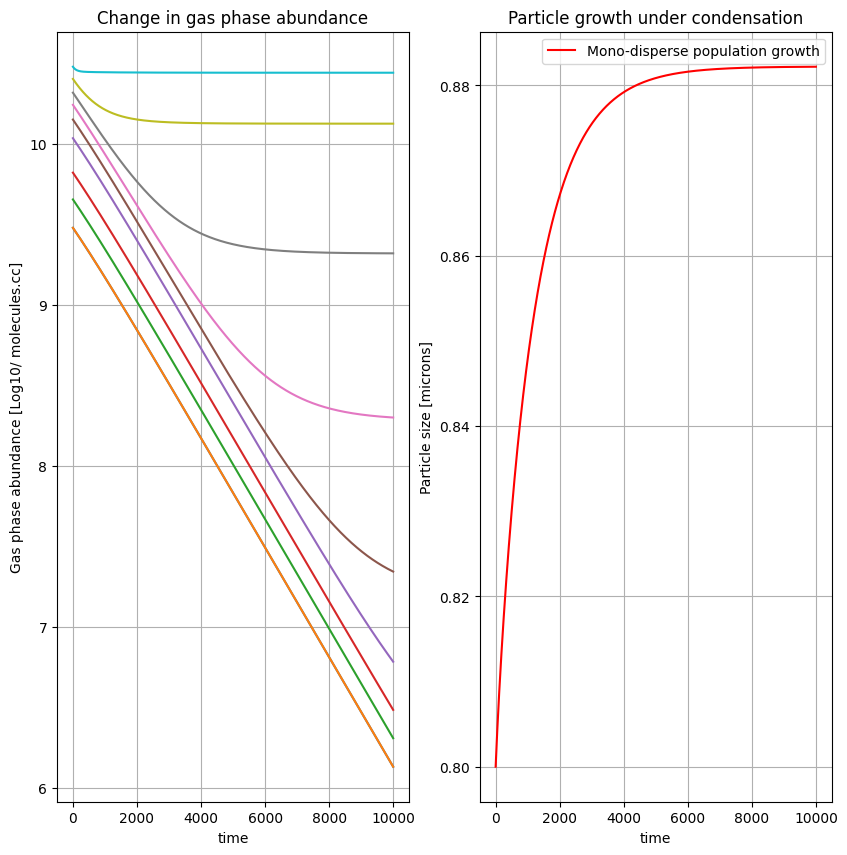

In [3]:
import numpy as np
from scipy.integrate import odeint # We only want to use the 'odeint' [Solve Initial Value Problems] from the scipy.integrate package
import matplotlib.pyplot as plt # Import Matplotlib so we can plot results
import pdb

Temp_K = 298.15

# --- Physical constants ---
Lv_water_vapour=2.5e3 # Latent heat of vapourisation of water [J/g] 
Rv=461.0 #Individual gas constant of water vapour [J/Kg.K]
Ra=287.0 #Gas constant for dry air [J/Kg.K]
R_gas=8.3144598 #Ideal gas constant [kg m2 s-2 K-1 mol-1]
R_gas_other=8.2057e-5 #Ideal gas constant [m3 atm K-1 mol-1]
GRAV=9.8; #Gravitational acceleration [(m/2)2]
cp=1005; #Specific heat capacity of air [J/Kg.K]
sigma=72.0e-3 # Assume surface tension of water (mN/m)
NA=6.0221409e+23 #Avogadros number
kb=1.380648E-23 #Boltzmanns constant

gamma = 2.0

# --- Properties of each gas in the volatility basis set ---
num_species = 10
num_bins = 1

# Molecular weight [g/mol]
mw_array=np.zeros((num_species), dtype=float)
mw_array[:]=200.0

log_c_star = np.linspace(-6, 3, num_species)
Cstar = np.power(10.0,log_c_star)
# Convert C* to saturation vapour pressure
P_sat = (Cstar*R_gas_other*Temp_K)/(1.0e6*mw_array)# atm
# Initialise an abundance of material in each volatility bin [micrograms/3]
abundance = np.zeros((num_species), dtype = float)
abundance[0] = 1.0
abundance[1] = 1.0
abundance[2] = 1.5
abundance[3] = 2.2
abundance[4] = 3.6
abundance[5] = 4.7
abundance[6] = 5.8
abundance[7] = 6.9
abundance[8] = 8.4
abundance[9] = 10.0
# Convert to molecules / cc 
gas_abundance = ((abundance*1.0e-6)/(mw_array))*1.0e-6*NA

# Accomodation coefficient [including water]
alpha_d_org=np.zeros((num_species), dtype=float)
alpha_d_org[:]=0.1 
# Density of condensing species
density_org=np.zeros((num_species), dtype=float)
density_org[:]=1400.0

# - Molecular diffusion coeffficient of each molecule in air. [cm2/s] - 
#We use an approximation to initialise this, but these values will also depend
#on the accomodation coefficient and size of particles condensing to. Following the
#approach in Topping et al (2013), diffusivity is calculated as 
DStar_org = 1.9*np.power(mw_array,-2.0/3.0)
# - Mean thermal velocity of each molecule [m/s] - 
mean_them_vel=np.power((8.0*R_gas*Temp_K)/(np.pi*(mw_array*1.0e-3)),0.5)
# - Mean free path for each molecule [m] - 
gamma_gas = ((3.0*DStar_org)/(mean_them_vel*1.0e2))*1.0e-2

# Create a monodisperse size distribution with a specific number of particles
# Assume each particle starts with an involatile core of absorptive organic with
# a mass of 200 g/mol and density 1400 km/m3. Store this information in an array
# as 'core'. This will ensure, in this example, that we do not get 100% evaporative loss

# Define total number of particles [per cc]
N_total = 30.0

core = np.zeros((num_bins), dtype=float)
core_abundance = np.zeros((num_bins), dtype=float)
density_core = np.zeros((num_bins), dtype=float)
core_mw = np.zeros((num_bins), dtype=float)

density_core[:] = 1400.0
core_mw[:] = 120.0

N_per_bin = np.zeros((num_bins), dtype=float)
N_per_bin[0] = N_total

# Define size
size_array = np.zeros((num_bins), dtype=float)
size_array[0] = 0.8 #microns
# Use the size to now calculate a concentration of a 'core' in molecules / cc
core_abundance[0] = (N_per_bin[0])*((4.0/3.0)*np.pi*np.power(size_array[0]*1.0e-6,3.0)*density_core[0]*1.0e3)
print("core_abundance in micrograms.m3 = ", core_abundance*1.0e12)

core_abundance[0] = (core_abundance[0] / core_mw[0])*NA
print("core_abundance in molecules.cc = ", core_abundance)

# New define an array that holds the molecular abundance of each gas and the concentration of 
# each gas in the size bins
array = np.zeros((num_species+num_species*num_bins), dtype=float)
array[0:num_species] = gas_abundance
array[num_species:num_species+num_species*num_bins] = 1.0e-20 # assuming we start with nothing 

#print(array)

def dy_dt(array,t):
    
    Cg_i_m_t = array[0:num_species] 
    
    # We are working with 16 size bins, each of which has an involatile core
    size_array = np.zeros((num_bins), dtype=float)
        
    # 1) Select a slice of y that represents this size bin \n')
    temp_array=array[num_species:num_species+num_species*num_bins]
    total_moles=np.sum(temp_array)+core_abundance[0]
    mole_fractions=temp_array/total_moles 
    density_array = np.zeros((num_species+num_bins), dtype=float)
    density_array[0:num_species]=density_org[0:num_species]
    density_array[num_species]=density_core[0]
    # Calculate total secondary organic mass 
    mass_array = np.zeros((num_species+1), dtype=float)
    mass_array[0:num_species] = (temp_array/NA)*mw_array
    mass_array[num_species] = (core_abundance[0]/NA)*core_mw[0]
    total_mass=np.sum(mass_array)
    mass_fractions_array=mass_array/total_mass
    density=1.0/(np.sum(mass_fractions_array/density_array))
    #3) In the below we need to remember that mass is in [g/cc] whilst density 
    # is in [kg/m3]. Thus we convert mass and number concentrations to kg/m3 and /m3 
    size_array[0]=((3.0*((total_mass*1.0e3)/(N_per_bin[0]*1.0e6)))/(4.0*np.pi*density))**(1.0/3.0) 
    #4) Knudsen number  \n') 
    # Calculate the Knudsen number for all condensing molecules based on this new size \n') 
    # This relies on mean free path for each species [cm] and particle radius [cm]\n') 
    Kn=gamma_gas/size_array[0]
    #5) Non-continuum regime correction  \n') 
    # Calculate a correction factor according to the continuum versus non-continuum regimes\n') 
    # Expression taken from Jacobson et al (2000), page 457. They reference:\n') 
    # Fuchs and Sutugin 1971\n') 
    # Pruppacher and Klett 1997\n') 
    Inverse_Kn=1.0/Kn 
    Correction_part1=(1.33e0+0.71e0*Inverse_Kn)/(1.0e0+Inverse_Kn) 
    Correction_part2=(4.0e0*(1.0e0-alpha_d_org))/(3.0e0*alpha_d_org) 
    Correction_part3=1.0e0+(Correction_part1+Correction_part2)*Kn
    Correction=1.0/Correction_part3 
    # 6) Kelvin factor  \n') 
    # Now calculate a kelvin factor for every semi-volatile compound in this size bin\n') 
    kelvin_factor=np.exp((4.0E0*mw_array*1.0e-3*sigma)/(R_gas*Temp_K*size_array[0]*2.0e0*density)) 
    #7) Equilibrium pressure above droplets  \n') 
    #Now calculate an equilibrium RH for every compound in this size bin \n') 
    #This is currently in atmospheres.  \n') 
    Pressure_eq=kelvin_factor*mole_fractions*P_sat*101325.0e0*gamma
    # 8) Calculate the equilibrium concentration equivalent \n') 
    # [Pa * molecules/mole * k mole  / Pa cm3 hence molecules/cm3] \n') 
    Cstar_i_m_t=Pressure_eq*(NA/(8.3144598e6*Temp_K))  
    #9) The droplet growth equation  \n') 
    # The following calculates the change in mass, per particle of this size. \n') 
    # The equation relies on the following parameters \n')  
    # and units. Always check units \n') 
    # radius [m] \n') 
    # DStar_org [m2/s] - pass in [cm2/s] so needs to be converted by *1.0E-4 \n') 
    # Pressure_gas [Pascals] \n') 
    # Pressure_eq [Pascals] \n') 
    # R_gas [m3 Pascals /(K mol)] \n') 
    # molw [g/mol] \n') 
    # T [K] \n') 
    # The units of the equation should therefore be g/s \n') 
    # ASTEM version - should be the same as the Jacobson version once coverted to molecules/cc/s \n') 
    k_i_m_t_part1 = DStar_org*Correction  
    k_i_m_t=4.0e0*np.pi*size_array[0]*1.0e2*N_per_bin[0]*k_i_m_t_part1    
    dm_dt=k_i_m_t*(Cg_i_m_t-Cstar_i_m_t) 
    
    #10) Now update the contribution to the ODEs being solved  \n') 
    # a) Add contributory loss from the gas phase to particle phase [this includes water] \n') 
    dy_dt_gas_matrix = np.zeros((num_species,num_bins), dtype=float)
    dy_dt_gas_matrix[0:num_species,0]=dm_dt
                       
    # b) Add a contributory gain to the particle phase from the gas phase \n') 
    #index1=num_species+((size_step+1)*num_species) 
    #index2=num_species+((size_step)*num_species)  
    
    dy_dt_array = np.zeros((num_species+num_species*num_bins), dtype=float)
    
    dy_dt_array[num_species:num_species+num_species*num_bins]=dm_dt[0:num_species] 
    
    dy_dt_array[0:num_species]=dy_dt_array[0:num_species]-np.sum(dy_dt_gas_matrix, axis=1)
                       
    return dy_dt_array

t = np.linspace(0, 10000, num=1000) # time span and steps (start, end, number of entries). Same as before, with 100 entries
solution = odeint(dy_dt, array, t, rtol=1.0e-6, atol=1.0e-20, tcrit=None)

size_array = np.zeros((1000), dtype=float)

# Lets now try to plot the size variation as a function of time
for step in range(solution.shape[0]):

    temp_array=solution[step,num_species:num_species+num_species*num_bins]
    total_moles=np.sum(temp_array)+core_abundance[0]
    mole_fractions=temp_array/total_moles 
    density_array = np.zeros((num_species+num_bins), dtype=float)
    density_array[0:num_species]=density_org[0:num_species]
    density_array[num_species]=density_core[0]
    # Calculate total secondary organic mass 
    mass_array = np.zeros((num_species+1), dtype=float)
    mass_array[0:num_species] = (temp_array/NA)*mw_array
    mass_array[num_species] = (core_abundance[0]/NA)*core_mw[0]
    total_mass=np.sum(mass_array)
    mass_fractions_array=mass_array/total_mass
    density=1.0/(np.sum(mass_fractions_array/density_array))
    #3) In the below we need to remember that mass is in [g/cc] whilst density 
    # is in [kg/m3]. Thus we convert mass and number concentrations to kg/m3 and /m3 
    size_array[step]=((3.0*((total_mass*1.0e3)/(N_per_bin[0]*1.0e6)))/(4.0*np.pi*density))**(1.0/3.0)
    #print(size_array[step])
    

fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(t, np.log10(solution[:,0:num_species]))
plt.grid()
plt.xlabel('time')
plt.ylabel('Gas phase abundance [Log10/ molecules.cc]')
plt.title('Change in gas phase abundance')

# Plot the decrease in gas phase abundance with the growth of the particle
#fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 2)
plt.plot(t, size_array*1.0e6, 'r-', label='Mono-disperse population growth')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('Particle size [microns]')
plt.title('Particle growth under condensation')
plt.show()

<div class="alert alert-block alert-success">
<b> Exercise 2. Examine the number concentration dependency on growth rates <a name="Exercise2"> </b> 
    
In the first example, the size of the aerosol is set to 150nm. Now change this to 800nm and observe the rate at which equilibria is reached. For example, once you change the size of the aerosol to 800nm you should produce a figure that resembles the following:

![title <](images/Prac3_ex2a.png)

<div class="alert alert-block alert-warning">
<b>HINT:</b> The faster equilibration timescales for smaller particles assumed the same saturation ratio, which you can force by ensuring the absorptive mass is the same in both bases. Aside from changing the size, what other parameter might you need to change? 
</div>



</div>

<div class="alert alert-block alert-success">
<b> Exercise 3. Change the properties of the condensed phase <a name="Exercise3"> </b> 
    
In the preceeding examples we have assumed an ideal condensed phase. In other words, there are no interactions taking place which change the solubility of any component in solution. In the equations defined at the beginning of this practical, the activity coefficient parameter is included in the definition of equilibrium partial pressure above the droplet surface:

| Parameter | Description | Units | Value (where constant) |
|------|------|------|------|
|....|....|....|....|
| $\gamma _{i,m,a}$ | Activity coefficient | unitless | NA |
|....|....|....|....|

Your task in this exercise is to modify this value to be 2.0 for all condensates in the droplet growth equation and assess the impact on growth rates. For the original 150nm case, you should arrive at the following figure:

![title <](Prac3_ex3.png)

Do you notice any difference on the final size? How might you better quantify this?

</div>

<div class="alert alert-block alert-success">
<b> Exercise 4. Run this code outside of a Jupyter notebook <a name="Exercise4"> </b> 
    
Now lets move out of our Jupyter notebooks for a short period. Can you take all of the code provided and run this using the Python interpreter?
    
In addition, let us see how long it takes for our simulation to run. To do this use the following template, which you can place at the end of your script.
    
```python    
def time_func():
    odeint(dy_dt, array, t, rtol=1.0e-6, atol=1.0e-20, tcrit=None)
print("Python",timeit.Timer(time_func).timeit(number=10)) 
```
you will also need to import the <code> timeit </code> module.

```python
import timeit
```
This module measures the time it takes for a function to be called over a certain number of times, which we set with the <code> number=10 </code> statement.
    
Does the simulation time change when you set the <code> rtol </code> value to 0.001? What is this value and how would you find out?

</div>